<a href="https://colab.research.google.com/github/LaFuego20/exchange-rate-forecasting/blob/main/ARIMA_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


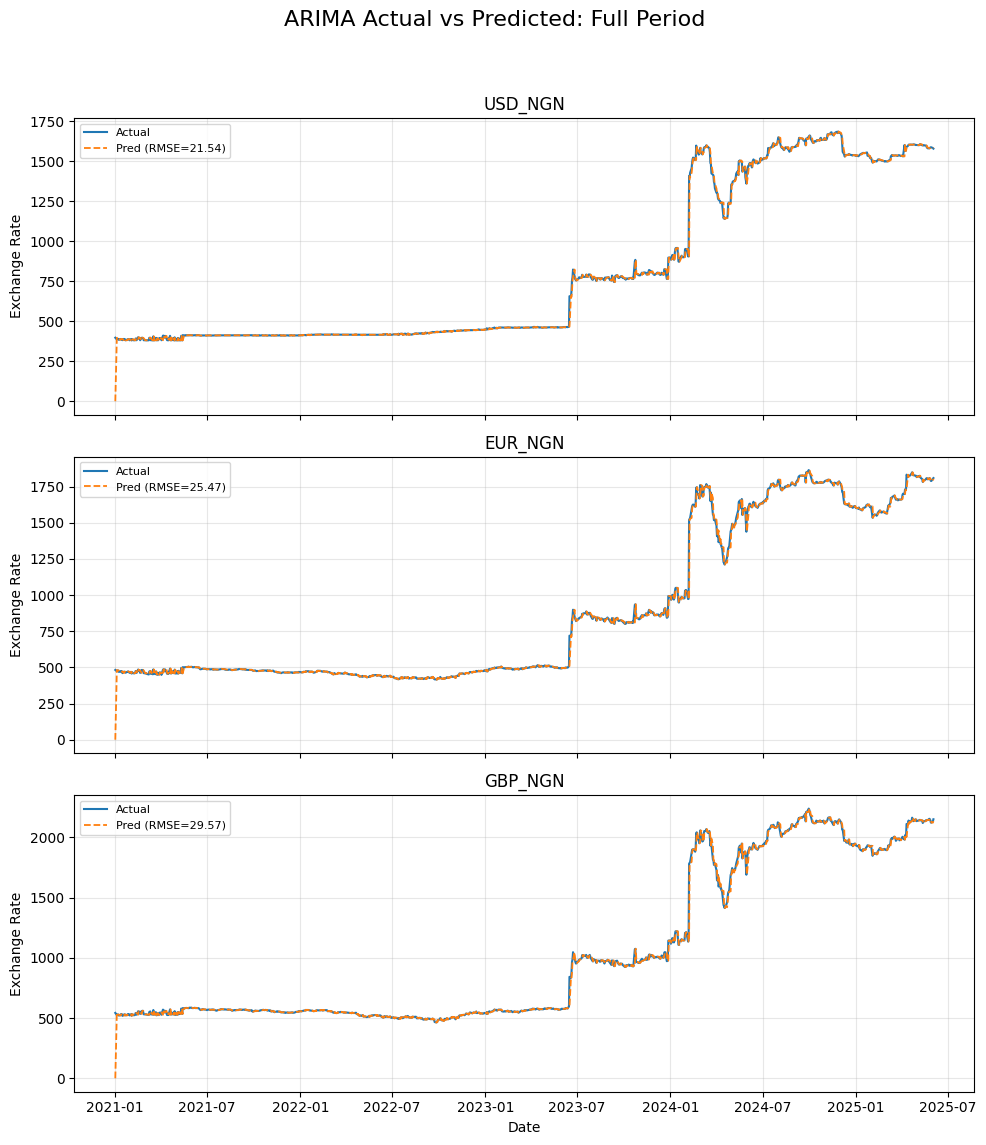

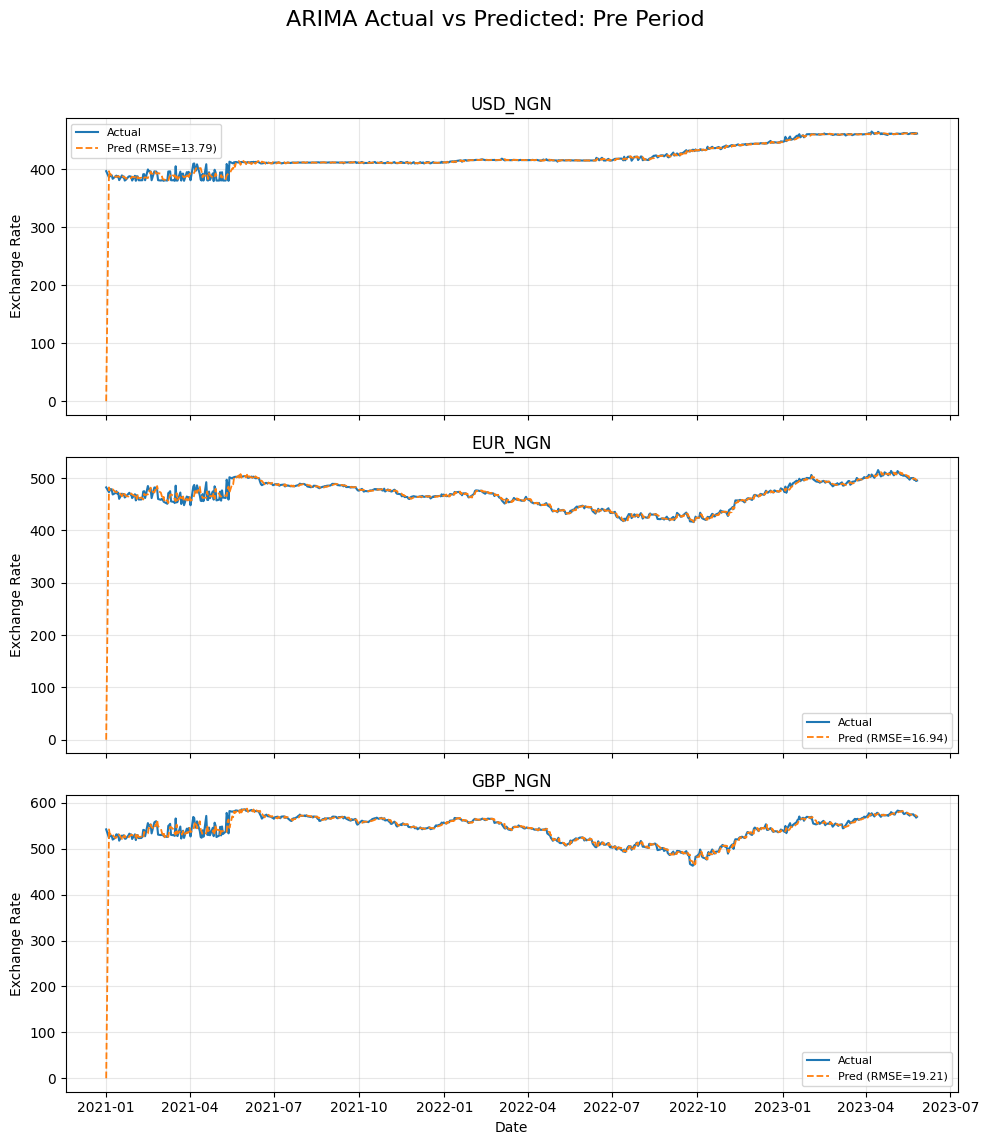

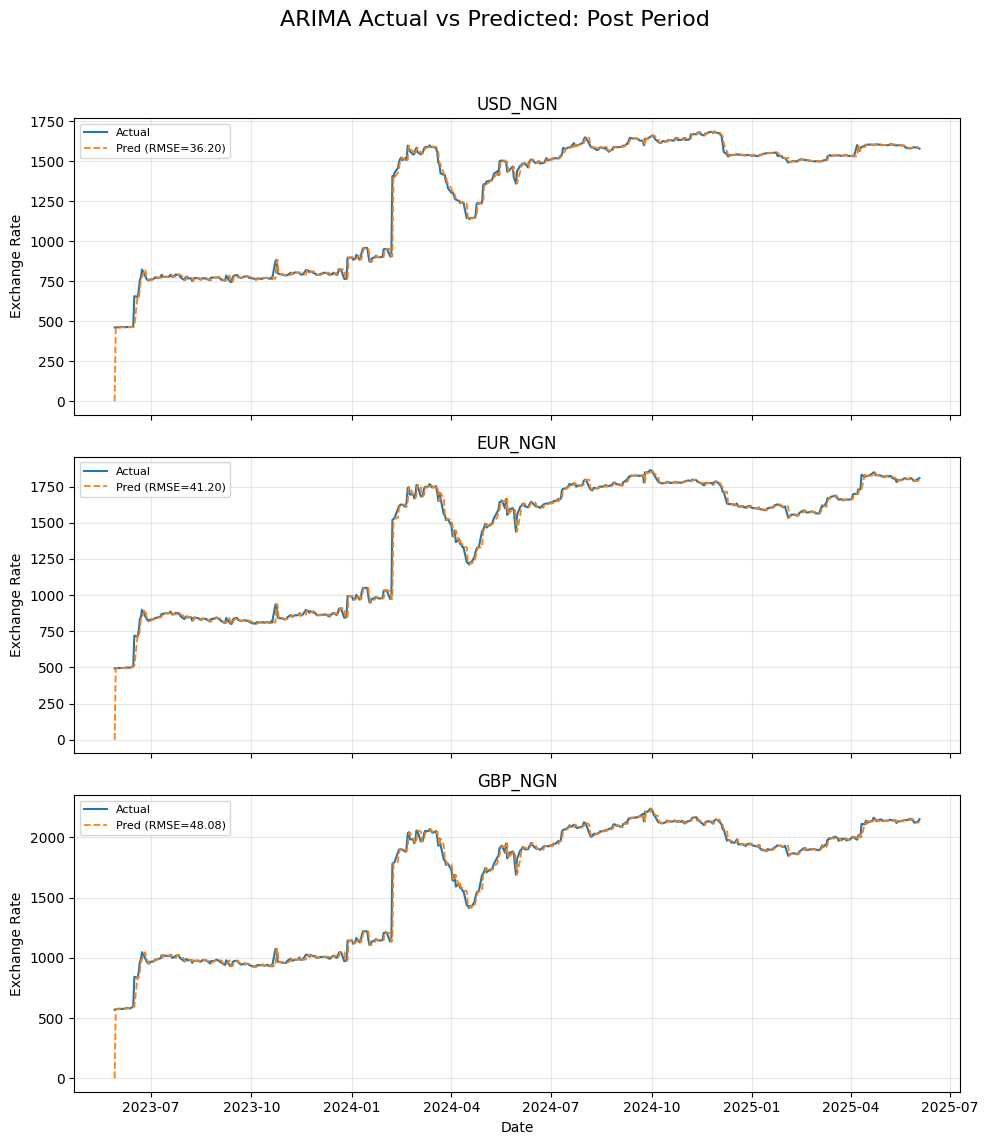


Reproduced metrics:


'Currency Period  RMSE_reproduced  MAE_reproduced\n USD_NGN   Full          21.5420          5.3896\n USD_NGN    Pre          13.7950          2.0259\n USD_NGN   Post          36.1966         11.9675\n EUR_NGN   Full          25.4707          7.3934\n EUR_NGN    Pre          16.9430          3.3448\n EUR_NGN   Post          41.1979         15.4446\n GBP_NGN   Full          29.5688          8.9785\n GBP_NGN    Pre          19.2106          4.0612\n GBP_NGN   Post          48.0788         18.7572'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os


CSV_PATH = "merged_exchange_rates.csv"
DATE_COL = "Date"
cutoff_date_str = "2023-05-29"
output_dir = "arima_outputs"
os.makedirs(output_dir, exist_ok=True)

# Convert cutoff_date string to datetime object
cutoff_date = pd.to_datetime(cutoff_date_str)


# ---------------------------
# ARIMA orders you provided
# ---------------------------
orders = {
    "USD_NGN": {"Full": (0,1,0), "Pre": (5,1,4), "Post": (0,1,0)},
    "EUR_NGN": {"Full": (0,1,0), "Pre": (3,1,5), "Post": (0,1,0)},
    "GBP_NGN": {"Full": (0,1,0), "Pre": (3,1,3), "Post": (0,1,0)}
}

# ---------------------------
# Helpers
# ---------------------------
def fit_arima_and_predict(series, order):
    """
    Fit ARIMA(order) to the given pandas Series (index = datetime) and produce in-sample predictions.
    Returns: pred_series (indexed like series), rmse, mae, model_fit
    """
    series = series.dropna()
    if len(series) == 0:
        raise ValueError("Series is empty after dropna().")
    try:
        model = ARIMA(series, order=order)
        # fit; statsmodels may warn—this is expected sometimes for high-order models
        model_fit = model.fit()
        # predict in-sample: use integer positions to avoid any freq issues
        n = len(series)
        pred_vals = model_fit.predict(start=0, end=n-1)
        pred_series = pd.Series(pred_vals, index=series.index)
        rmse = float(np.sqrt(mean_squared_error(series.values, pred_series.values)))
        mae = float(mean_absolute_error(series.values, pred_series.values))
        return pred_series, rmse, mae, model_fit
    except Exception as e:
        # print(f"[ERROR] ARIMA fit/predict failed for order={order}: {e}") # Exclude error printing
        raise RuntimeError(f"ARIMA fit/predict failed for order={order}: {e}") # Re-raise exception


# ---------------------------
# Load data
# ---------------------------
df = pd.read_csv(CSV_PATH, parse_dates=[DATE_COL], date_format='%d/%m/%Y')
df.set_index(DATE_COL, inplace=True)

required_cols = ["USD_NGN", "EUR_NGN", "GBP_NGN"]
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"Required column '{c}' not found in CSV. Columns found: {list(df.columns)}")

# ---------------------------
# Prepare period series
# ---------------------------
periods = ["Full", "Pre", "Post"]
actual = {p: {} for p in periods}
predicted = {p: {} for p in periods}
metrics = []  # list of [Currency, Period, RMSE, MAE]

# Find the index location for the cutoff date
cutoff_loc = df.index.searchsorted(cutoff_date)


for cur in required_cols:
    # Full: entire available series
    full_series = df[cur].dropna()
    actual["Full"][cur] = full_series
    try:
        pred_full, rmse_full, mae_full, _ = fit_arima_and_predict(full_series, orders[cur]["Full"])
    except Exception as e:
        # print(f"[ERROR] Full ARIMA for {cur}: {e}") # Exclude error printing
        pred_full = pd.Series(index=full_series.index, dtype=float)
        rmse_full = np.nan
        mae_full = np.nan
    predicted["Full"][cur] = pred_full
    metrics.append([cur, "Full", rmse_full, mae_full])

    # Pre: up to cutoff_date (exclusive of cutoff_date)
    pre_series = df.iloc[:cutoff_loc, df.columns.get_loc(cur)].dropna()
    actual["Pre"][cur] = pre_series
    try:
        pred_pre, rmse_pre, mae_pre, _ = fit_arima_and_predict(pre_series, orders[cur]["Pre"])
    except Exception as e:
        # print(f"[ERROR] Pre ARIMA for {cur}: {e}") # Exclude error printing
        pred_pre = pd.Series(index=pre_series.index, dtype=float)
        rmse_pre = np.nan
        mae_pre = np.nan
    predicted["Pre"][cur] = pred_pre
    metrics.append([cur, "Pre", rmse_pre, mae_pre])

    # Post: from cutoff_date to end (inclusive of cutoff_date if it exists)
    post_series = df.iloc[cutoff_loc:, df.columns.get_loc(cur)].dropna()
    actual["Post"][cur] = post_series
    try:
        pred_post, rmse_post, mae_post, _ = fit_arima_and_predict(post_series, orders[cur]["Post"])
    except Exception as e:
        # print(f"[ERROR] Post ARIMA for {cur}: {e}") # Exclude error printing
        pred_post = pd.Series(index=post_series.index, dtype=float)
        rmse_post = np.nan
        mae_post = np.nan
    predicted["Post"][cur] = pred_post
    metrics.append([cur, "Post", rmse_post, mae_post])


# ---------------------------
# Calculate and Display Reproduced Metrics table
# ---------------------------
results_df = pd.DataFrame(metrics, columns=["Currency", "Period", "RMSE_reproduced", "MAE_reproduced"])
# Exclude saving comparison table and dissertation metrics
# results_df.to_csv(os.path.join(output_dir, "arima_reproduced_metrics.csv"), index=False)
# print("Saved reproduced metrics to:", os.path.join(output_dir, "arima_reproduced_metrics.csv"))

# ---------------------------
# Plot: 3 separate figures, each with 3 vertical subplots (USD, EUR, GBP) per period
# ---------------------------
currencies = required_cols
periods = ["Full", "Pre", "Post"]

for period in periods:
    fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True) # 3 rows, 1 column for vertical subplots
    fig.suptitle(f'ARIMA Actual vs Predicted: {period} Period', fontsize=16)

    for i, cur in enumerate(currencies):
        ax = axes[i]

        a_series = actual[period][cur]
        p_series = predicted[period][cur]
        # Check if RMSE value is available before trying to format
        rmse_value = results_df.loc[(results_df.Currency==cur)&(results_df.Period==period),'RMSE_reproduced'].values[0]
        rmse_label = f"Pred (RMSE={rmse_value:.2f})" if not np.isnan(rmse_value) else "Pred (RMSE: N/A)"

        if not a_series.empty and not p_series.empty:
            ax.plot(a_series.index, a_series.values, label="Actual", linestyle="-", linewidth=1.5)
            ax.plot(p_series.index, p_series.values, label=rmse_label,
                    linestyle="--", linewidth=1.3)


        ax.set_title(f"{cur}")
        ax.set_ylabel("Exchange Rate")
        ax.legend(fontsize=8)
        ax.grid(alpha=0.3)

    # Set xlabel for the bottom subplot only
    axes[-1].set_xlabel("Date")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()
    fig_path = os.path.join(output_dir, f"arima_actual_vs_predicted_{period.lower()}.png")
    fig.savefig(fig_path, dpi=300, bbox_inches="tight")
    # print(f"Saved figure for {period} period to:", fig_path) # Exclude saving figure message

# ---------------------------
# Display Reproduced Metrics table
# ---------------------------
print("\nReproduced metrics:")
display(results_df.to_string(index=False, float_format="%.4f"))